## Bibliotecas

In [7]:

import os
import PIL
import cv2
import time
import PIL.Image
import pathlib
import cv2 as cv
import statistics
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from skimage import transform as tf_sk
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from IPython.display import clear_output
from skimage.color import rgb2gray, gray2rgb
from skimage import restoration, filters, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.io import imread, imsave, imshow, imread_collection

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA

## Manipulacao dos Dados

In [8]:
# batch_size = 32
img_size = 512

In [9]:
data_dir = pathlib.Path("Dataset/BID Sample Dataset/")

image_count = list(data_dir.glob('*/*.jpg'))
# str(image_count).count("CPF")

In [14]:
image_count

[WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000000_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000001_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000002_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000003_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000004_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000005_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000006_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000007_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000008_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000009_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000010_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000011_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000012_in.jpg'),
 WindowsPath('Dataset/BID Sample Dataset/CNH_Aberta/00000013_in.jpg'),
 Windo

In [16]:
images_cnh_aberta = list()
images_cnh_frente = list()
images_cnh_verso = list()
images_cpf_frente = list()
images_cpf_verso = list()
images_rg_aberto = list()
images_rg_frente = list()
images_rg_verso = list()
for img in image_count:
    if str(img).count("CNH_Aberta"):
        images_cnh_aberta.append(str(img))
    elif str(img).count("CNH_Frente"):
        images_cnh_frente.append(str(img))
    elif str(img).count("CNH_Verso"):
        images_cnh_verso.append(str(img))
    elif str(img).count("CPF_Frente"):
        images_cpf_frente.append(str(img))
    elif str(img).count("CPF_Verso"):
        images_cpf_verso.append(str(img))
    elif str(img).count("RG_Aberto"):
        images_rg_aberto.append(str(img))
    elif str(img).count("RG_Frente"):
        images_rg_frente.append(str(img))
    elif str(img).count("RG_Verso"):
        images_rg_verso.append(str(img))
    else:
        print(img)
        print("Algo deu Errado!")
        break


In [47]:
print(len(images_cnh_aberta))
print(len(images_cnh_frente))
print(len(images_cnh_verso))
print(len(images_cpf_frente))
print(len(images_cpf_verso))
print(len(images_rg_aberto))
print(len(images_rg_frente))
print(len(images_rg_verso))

images = imread_collection(images_cnh_aberta+
images_cnh_frente+
images_cnh_verso+
images_cpf_frente+
images_cpf_verso+
images_rg_aberto+
images_rg_frente+
images_rg_verso)


34
36
36
36
36
36
36
36


Text(0.5, 1.0, 'Exemplo de RG')

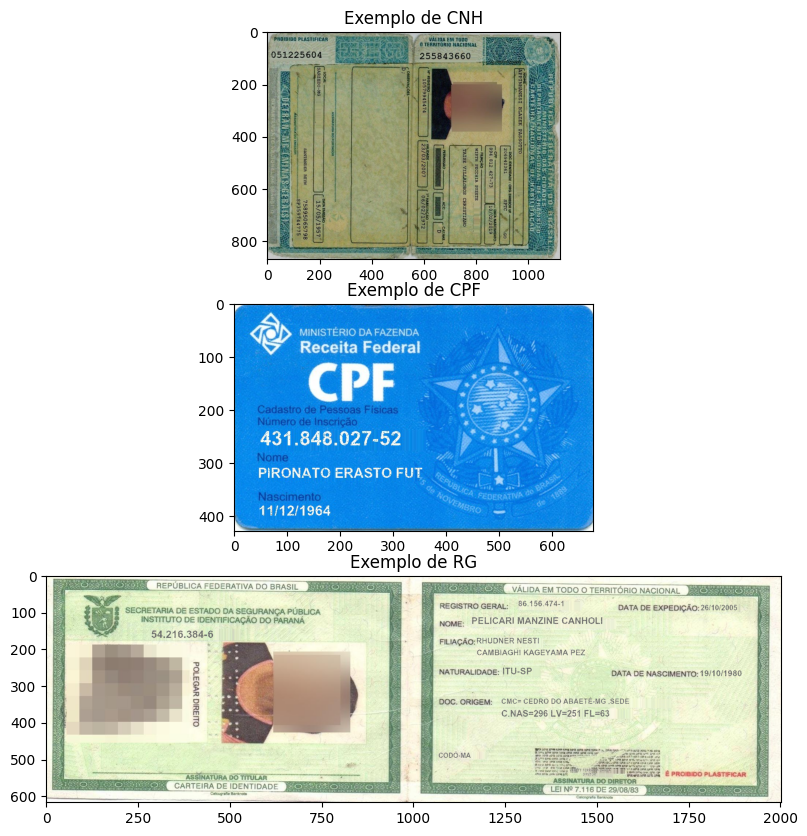

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(images[0])
ax[0].set_title('Exemplo de CNH')
ax[1].imshow(images[110])
ax[1].set_title('Exemplo de CPF')
ax[2].imshow(images[180])
ax[2].set_title('Exemplo de RG')


In [21]:
labels = np.concatenate((np.zeros(len(images_cnh_aberta)), np.ones(
    len(images_cnh_frente)), np.ones(len(images_cnh_verso)) + 1, np.ones(len(images_cpf_frente)) + 2, np.ones(len(images_cpf_frente)) + 3,
                         np.ones(len(images_cpf_frente)) + 4, np.ones(len(images_cpf_frente)) + 5, np.ones(len(images_cpf_frente)) + 6))
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6.

## Funcoes

In [22]:
def conv_bordas(imagem, centro, borda='ignore'):

    if borda == 'ignore':
        return imagem

    else:
        print("Borda desconhecida!")
        return None


In [23]:
def convolucao(imagem, filtro, borda='ignore'):
    imagem_h, imagem_w = imagem.shape[:2]
    kernel_h, kernel_w = filtro.shape[:2]

    if borda == 'ignore':
        centro = ((kernel_h-1)//2)*(-1)
    else:
        centro = ((kernel_h-1)//2)

    imagem = np.array(conv_bordas(imagem, centro, borda))

    #Verifica camadas
    camadas = len(imagem.shape)
    if(camadas == 2):
        # Inicializa imagem de saída com zeros
        imagem_processada = np.array(imagem)
        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                    2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                # Aplica o filtro de convolução
                #print(sub_imagem.shape)
                imagem_processada[i, j] = np.sum(sub_imagem * filtro)

        if borda != 'ignore':
            # Remove as bordas adicionadas
            imagem_processada = imagem_processada[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]

        imagem_processada = cv.normalize(
            imagem_processada,  None, 0, 255, cv.NORM_MINMAX)

    else:

        imagemr = imagem[:, :, 0]
        imagemg = imagem[:, :, 1]
        imagemb = imagem[:, :, 2]
        # Inicializa cada camada da imagem de saída com zeros
        imagem_processadar = np.array(imagemr)
        imagem_processadag = np.array(imagemg)
        imagem_processadab = np.array(imagemb)

        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                      2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                      2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                      2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]

                # Aplica o filtro de convolução
                imagem_processadar[i, j] = np.sum(sub_imagemr * filtro)
                imagem_processadag[i, j] = np.sum(sub_imagemg * filtro)
                imagem_processadab[i, j] = np.sum(sub_imagemb * filtro)

        if borda != 'ignore':
            # Remove as bordas adicionadas

            imagem_processadar = imagem_processadar[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadag = imagem_processadag[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadab = imagem_processadab[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
        imagem_processadar = cv.normalize(
            imagem_processadar,  None, 0, 255, cv.NORM_MINMAX)
        imagem_processadag = cv.normalize(
            imagem_processadag,  None, 0, 255, cv.NORM_MINMAX)
        imagem_processadab = cv.normalize(
            imagem_processadab,  None, 0, 255, cv.NORM_MINMAX)

        imagem_processada = np.dstack(
            (imagem_processadar, imagem_processadag, imagem_processadab))
    return imagem_processada


In [24]:
def convolucao_q2(imagem, filtro, borda, tipo):
    imagem_h, imagem_w = imagem.shape[:2]
    kernel_h = filtro[0]
    kernel_w = filtro[1]

    if borda == 'ignore':
      centro = ((kernel_h-1)//2)*(-1)
    else:
      centro = ((kernel_h-1)//2)

    imagem = conv_bordas(imagem, centro, borda)

    #Verifica camadas
    camadas = len(imagem.shape)
    if(camadas == 2):
        # Inicializa imagem de saída com zeros
        imagem_processada = np.zeros_like(imagem)
        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                if tipo == 'mediana':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = np.median(sub_imagem)
                if tipo == 'moda':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = statistics.mode(
                        np.ravel(sub_imagem))
                if tipo == 'maximo':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = sub_imagem.max()
                if tipo == 'minimo':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = sub_imagem.min()

    else:

        imagemr = imagem[:, :, 0]
        imagemg = imagem[:, :, 1]
        imagemb = imagem[:, :, 2]
        # Inicializa cada camada da imagem de saída com zeros
        imagem_processadar = np.zeros_like(imagemr)
        imagem_processadag = np.zeros_like(imagemg)
        imagem_processadab = np.zeros_like(imagemb)

        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                if tipo == 'mediana':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = np.median(sub_imagemr)
                    imagem_processadag[i, j] = np.median(sub_imagemg)
                    imagem_processadab[i, j] = np.median(sub_imagemb)
                if tipo == 'moda':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = statistics.mode(
                        np.ravel(sub_imagemr))
                    imagem_processadag[i, j] = statistics.mode(
                        np.ravel(sub_imagemg))
                    imagem_processadab[i, j] = statistics.mode(
                        np.ravel(sub_imagemb))
                if tipo == 'maximo':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = sub_imagemr.max()
                    imagem_processadag[i, j] = sub_imagemg.max()
                    imagem_processadab[i, j] = sub_imagemb.max()
                if tipo == 'minimo':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = sub_imagemr.min()
                    imagem_processadag[i, j] = sub_imagemg.min()
                    imagem_processadab[i, j] = sub_imagemb.min()
        if borda != 'ignore':
            # Remove as bordas adicionadas
            imagem_processadar = imagem_processadar[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadag = imagem_processadag[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadab = imagem_processadab[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]

        imagem_processada = np.dstack(
            (imagem_processadar, imagem_processadag, imagem_processadab))
    return imagem_processada


In [43]:
def seg_otsu(path_img):

    img = imread(path_img)

    if len(img.shape) > 2:
        img = rgb2gray(img)

    threshold = filters.threshold_otsu(img)
    binarized_img = (img > threshold)*1

    binarized_img_norm = cv2.normalize(src=binarized_img, dst=None, alpha=0,
                                       beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Se for o Linux
    # name_img = str(path_img).split('/')[-1]
    # Se for o Windows
    name_img = str(path_img).split('\\')[-1]

    os.makedirs("Dataset/seg_otsu/", exist_ok=True)
    imsave('Dataset/seg_otsu/{}'.format(name_img), binarized_img_norm)


In [42]:
def seg_niblack(path_img):

    img = imread(path_img)

    if len(img.shape) > 2:
        img = rgb2gray(img)

    threshold = filters.threshold_niblack(img)
    binarized_img = (img > threshold)*1

    binarized_img_norm = cv2.normalize(src=binarized_img, dst=None, alpha=0,
                                       beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Se for o Linux
    # name_img = str(path_img).split('/')[-1]
    # Se for o Windows
    name_img = str(path_img).split('\\')[-1]
    
    os.makedirs("Dataset/seg_niblack/", exist_ok=True)
    imsave('Dataset/seg_niblack/{}'.format(name_img), binarized_img_norm)


## Etapa 01 - Filtros de pre-processamento

In [27]:
count = 0
for img in images:
    img_filter_minimo=convolucao_q2(rgb2gray(img),[13,13],'ignore', "minimo")
    
    img_filter_minimo = cv2.normalize(src=img_filter_minimo, dst=None, alpha=0,
                                      beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    imsave('Dataset/filtro_minimo/{}.png'.format(count), img_filter_minimo, check_contrast=False)
    
    count += 1

## Etapa 02 - Segmentacao

In [28]:
data_dir_fil = pathlib.Path("Dataset/filtro_minimo/")

filtered_image = list(data_dir_fil.glob('*'))


In [37]:
filtered_image[5]

WindowsPath('Dataset/filtro_minimo/102.png')

In [44]:
for img in filtered_image:
    seg_otsu(img)
    seg_niblack(img)


In [53]:
data_dir_fil = pathlib.Path("Dataset/seg_otsu/")

filtered_image = list(data_dir_fil.glob('*'))

listAux = list()
for img in filtered_image:
    listAux.append(str(img))

images_seg = imread_collection(listAux)


In [55]:
images_segmented = list()
for in_img in range(len(images)):
    images_segmented.append(cv2.bitwise_and(images[in_img], images[in_img], mask=images_seg[in_img]))

## Etapa 03 - Descricao

#### - Using GLCM

In [25]:
# data_dir_fil = pathlib.Path("../seg_otsu/imagem_filtrada/")

# filtered_image = list(data_dir_fil.glob('*'))

# listAux = list()
# for img in filtered_image:
#     listAux.append(str(img))

# images = imread_collection(listAux)


In [56]:
d = 2

##### Imagens segmentadas

In [57]:
features = np.zeros((len(labels), 18))  # 6 features x 3 color channels
start = time.time()

for id_im, imagem in enumerate(images_segmented):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(
        id_im+1, len(images_segmented)))
    for id_ch in range(3):
        matrix0 = graycomatrix(imagem[:, :, id_ch], [d], [0], normed=True)
        matrix1 = graycomatrix(imagem[:, :, id_ch], [d], [np.pi/4], normed=True)
        matrix2 = graycomatrix(imagem[:, :, id_ch], [d], [np.pi/2], normed=True)
        matrix3 = graycomatrix(imagem[:, :, id_ch], [d], [3*np.pi/4], normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4
        props = np.zeros((6))
        props[0] = graycoprops(matrix, 'contrast')
        props[1] = graycoprops(matrix, 'dissimilarity')
        props[2] = graycoprops(matrix, 'homogeneity')
        props[3] = graycoprops(matrix, 'energy')
        props[4] = graycoprops(matrix, 'correlation')
        props[5] = graycoprops(matrix, 'ASM')
        features[id_im, id_ch*6:(id_ch+1)*6] = props

end = time.time()
print(end - start)


Extraindo atributos: 286 imagens processadas de 286.
6.461158752441406


##### Imagens Normais

In [58]:
features_2 = np.zeros((len(labels), 18))  # 6 features_2 x 3 color channels
start = time.time()

for id_im, imagem in enumerate(images):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(
        id_im+1, len(images)))
    for id_ch in range(3):
        matrix0 = graycomatrix(imagem[:, :, id_ch], [d], [0], normed=True)
        matrix1 = graycomatrix(imagem[:, :, id_ch], [
                               d], [np.pi/4], normed=True)
        matrix2 = graycomatrix(imagem[:, :, id_ch], [
                               d], [np.pi/2], normed=True)
        matrix3 = graycomatrix(imagem[:, :, id_ch], [d], [
                               3*np.pi/4], normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4
        props = np.zeros((6))
        props[0] = graycoprops(matrix, 'contrast')
        props[1] = graycoprops(matrix, 'dissimilarity')
        props[2] = graycoprops(matrix, 'homogeneity')
        props[3] = graycoprops(matrix, 'energy')
        props[4] = graycoprops(matrix, 'correlation')
        props[5] = graycoprops(matrix, 'ASM')
        features_2[id_im, id_ch*6:(id_ch+1)*6] = props

end = time.time()
print(end - start)


Extraindo atributos: 286 imagens processadas de 286.
8.364901304244995


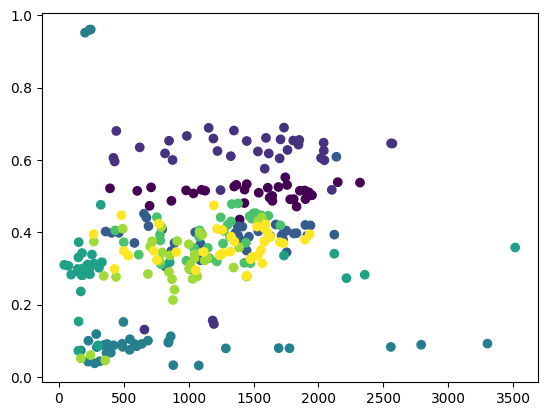

In [59]:
plt.scatter(features[:,0],features[:,3],c=labels)

In [60]:
pca = PCA()
pca.fit(features)
transform = pca.transform(features)
print(np.sum(pca.explained_variance_ratio_[0:3]))


0.9999699400245298


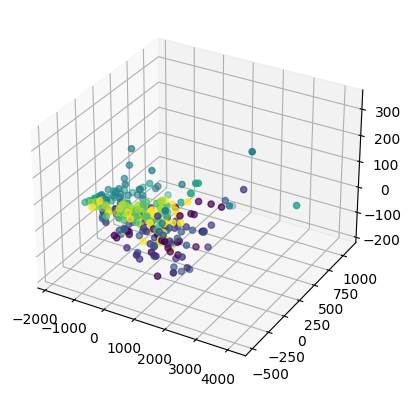

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transform[:,0],transform[:,1],transform[:,2],c=labels)

#### - Using HOG

In [62]:
hog_features = []
for image in images_segmented:
    #Deixar todas as imagens do mesmo tamanho
    resized_image = tf_sk.resize(
        image, (img_size, img_size), anti_aliasing=True)
    fd = hog(resized_image, orientations=8, pixels_per_cell=(16, 16),
             cells_per_block=(1, 1), visualize=False, block_norm='L2-Hys', channel_axis=2)
    hog_features.append(fd)
    
hog_features = np.array(hog_features)


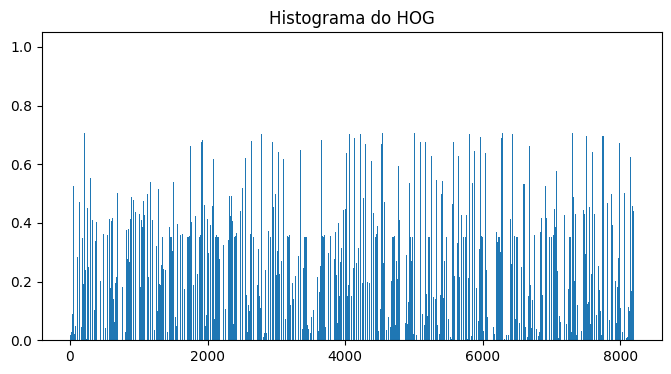

In [63]:
# Plot de cada imagem


fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(range(len(hog_features[0])), hog_features[0])
ax.set_title('Histograma do HOG')

plt.show()


## Etapa 04 - Classificacao

### Using RandomForest

#### - Using GLCM

In [67]:
train = 0.8
test = 1-train

In [68]:
#Imagens segmentadas

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test)

#Imagens normais
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    features_2, labels, test_size=test)


In [69]:
#Imagens Segmentadas

c_rf = RandomForestClassifier()
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy Random Forest: {}'.format(acc_rf))


Accuracy Random Forest: 0.7241379310344828


In [70]:
#Imagens Normais

c_rf = RandomForestClassifier()
c_rf.fit(X_train_2, y_train_2)
pred = c_rf.predict(X_test_2)
acc_rf = accuracy_score(y_test_2, pred)
print('Accuracy Random Forest: {}'.format(acc_rf))


Accuracy Random Forest: 0.4482758620689655


In [71]:
#Imagens Segmentadas

acc_rf = []
c_rf = RandomForestClassifier()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test)
    c_rf.fit(X_train, y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Mean accuracy Random Forest: 0.7449999999999999+-0.051337346899528416


In [73]:
#Imagens Normais

acc_rf = []
c_rf = RandomForestClassifier()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        features_2, labels, test_size=test)
    c_rf.fit(X_train, y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Mean accuracy Random Forest: 0.5722413793103447+-0.05706323546605936


In [74]:

def rf_parameter_estimation(xEst, yEst):

    clf = RandomForestClassifier(n_estimators=20)
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10, 1000, 50),
                       "max_depth": range(1, 100),
                       "max_features": sp_randint(1, xEst.shape[1]),
                       "min_samples_split": sp_randint(2, xEst.shape[1]),
                       "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                       "bootstrap": [True, False],
                       "criterion": ["gini", "entropy"]}

    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search, scoring=make_scorer(accuracy_score))

    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))


In [81]:
# Imagens Segmentadas

start = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test)

parameters = rf_parameter_estimation(X_train, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)

end = time.time()
print(end - start)

print('Random Forest Accuracy: ', acc_rf)


Model with rank: 1
Mean validation score: 0.728 (std: 0.034)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 86, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 110}
Model with rank: 2
Mean validation score: 0.715 (std: 0.025)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 22, 'max_features': 14, 'min_samples_leaf': 16, 'min_samples_split': 4, 'n_estimators': 860}
Model with rank: 3
Mean validation score: 0.706 (std: 0.042)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 35, 'max_features': 14, 'min_samples_leaf': 7, 'min_samples_split': 9, 'n_estimators': 360}
61.764347076416016
Random Forest Accuracy:  0.7413793103448276


In [80]:
# Imagens Normais

start = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    features_2, labels, test_size=test)

parameters = rf_parameter_estimation(X_train, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)

end = time.time()
print(end - start)

print('Random Forest Accuracy: ', acc_rf)


Model with rank: 1
Mean validation score: 0.544 (std: 0.056)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 60}
Model with rank: 2
Mean validation score: 0.522 (std: 0.070)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 87, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 410}
Model with rank: 3
Mean validation score: 0.521 (std: 0.077)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 94, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 960}
63.89518904685974
Random Forest Accuracy:  0.5517241379310345


##### Classification using PCA

In [82]:
components = [6,8,10,12]

In [83]:
def pca(X_train, X_test, y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train, y_train)
    transform = pca.transform(X_test)
    return transform


In [84]:
results_rf = np.zeros(5)

start = time.time()
for id_comp, comp in enumerate(components):

    print('-------------', 'n comp. = ', comp, '-------------')

    X_train_pca = pca(X_train, X_train, y_train, comp)

    X_test_pca = pca(X_train, X_test, y_train, comp)

    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca, y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc


end = time.time()
print(end - start)


------------- n comp. =  6 -------------
Model with rank: 1
Mean validation score: 0.631 (std: 0.040)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 660}
Model with rank: 2
Mean validation score: 0.623 (std: 0.066)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 37, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 410}
Model with rank: 3
Mean validation score: 0.622 (std: 0.075)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 79, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 460}
------------- n comp. =  8 -------------
Model with rank: 1
Mean validation score: 0.623 (std: 0.047)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 99, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 510}
Model with rank: 2
Mean validation sco

Text(0.5, 1.0, 'Helmets')

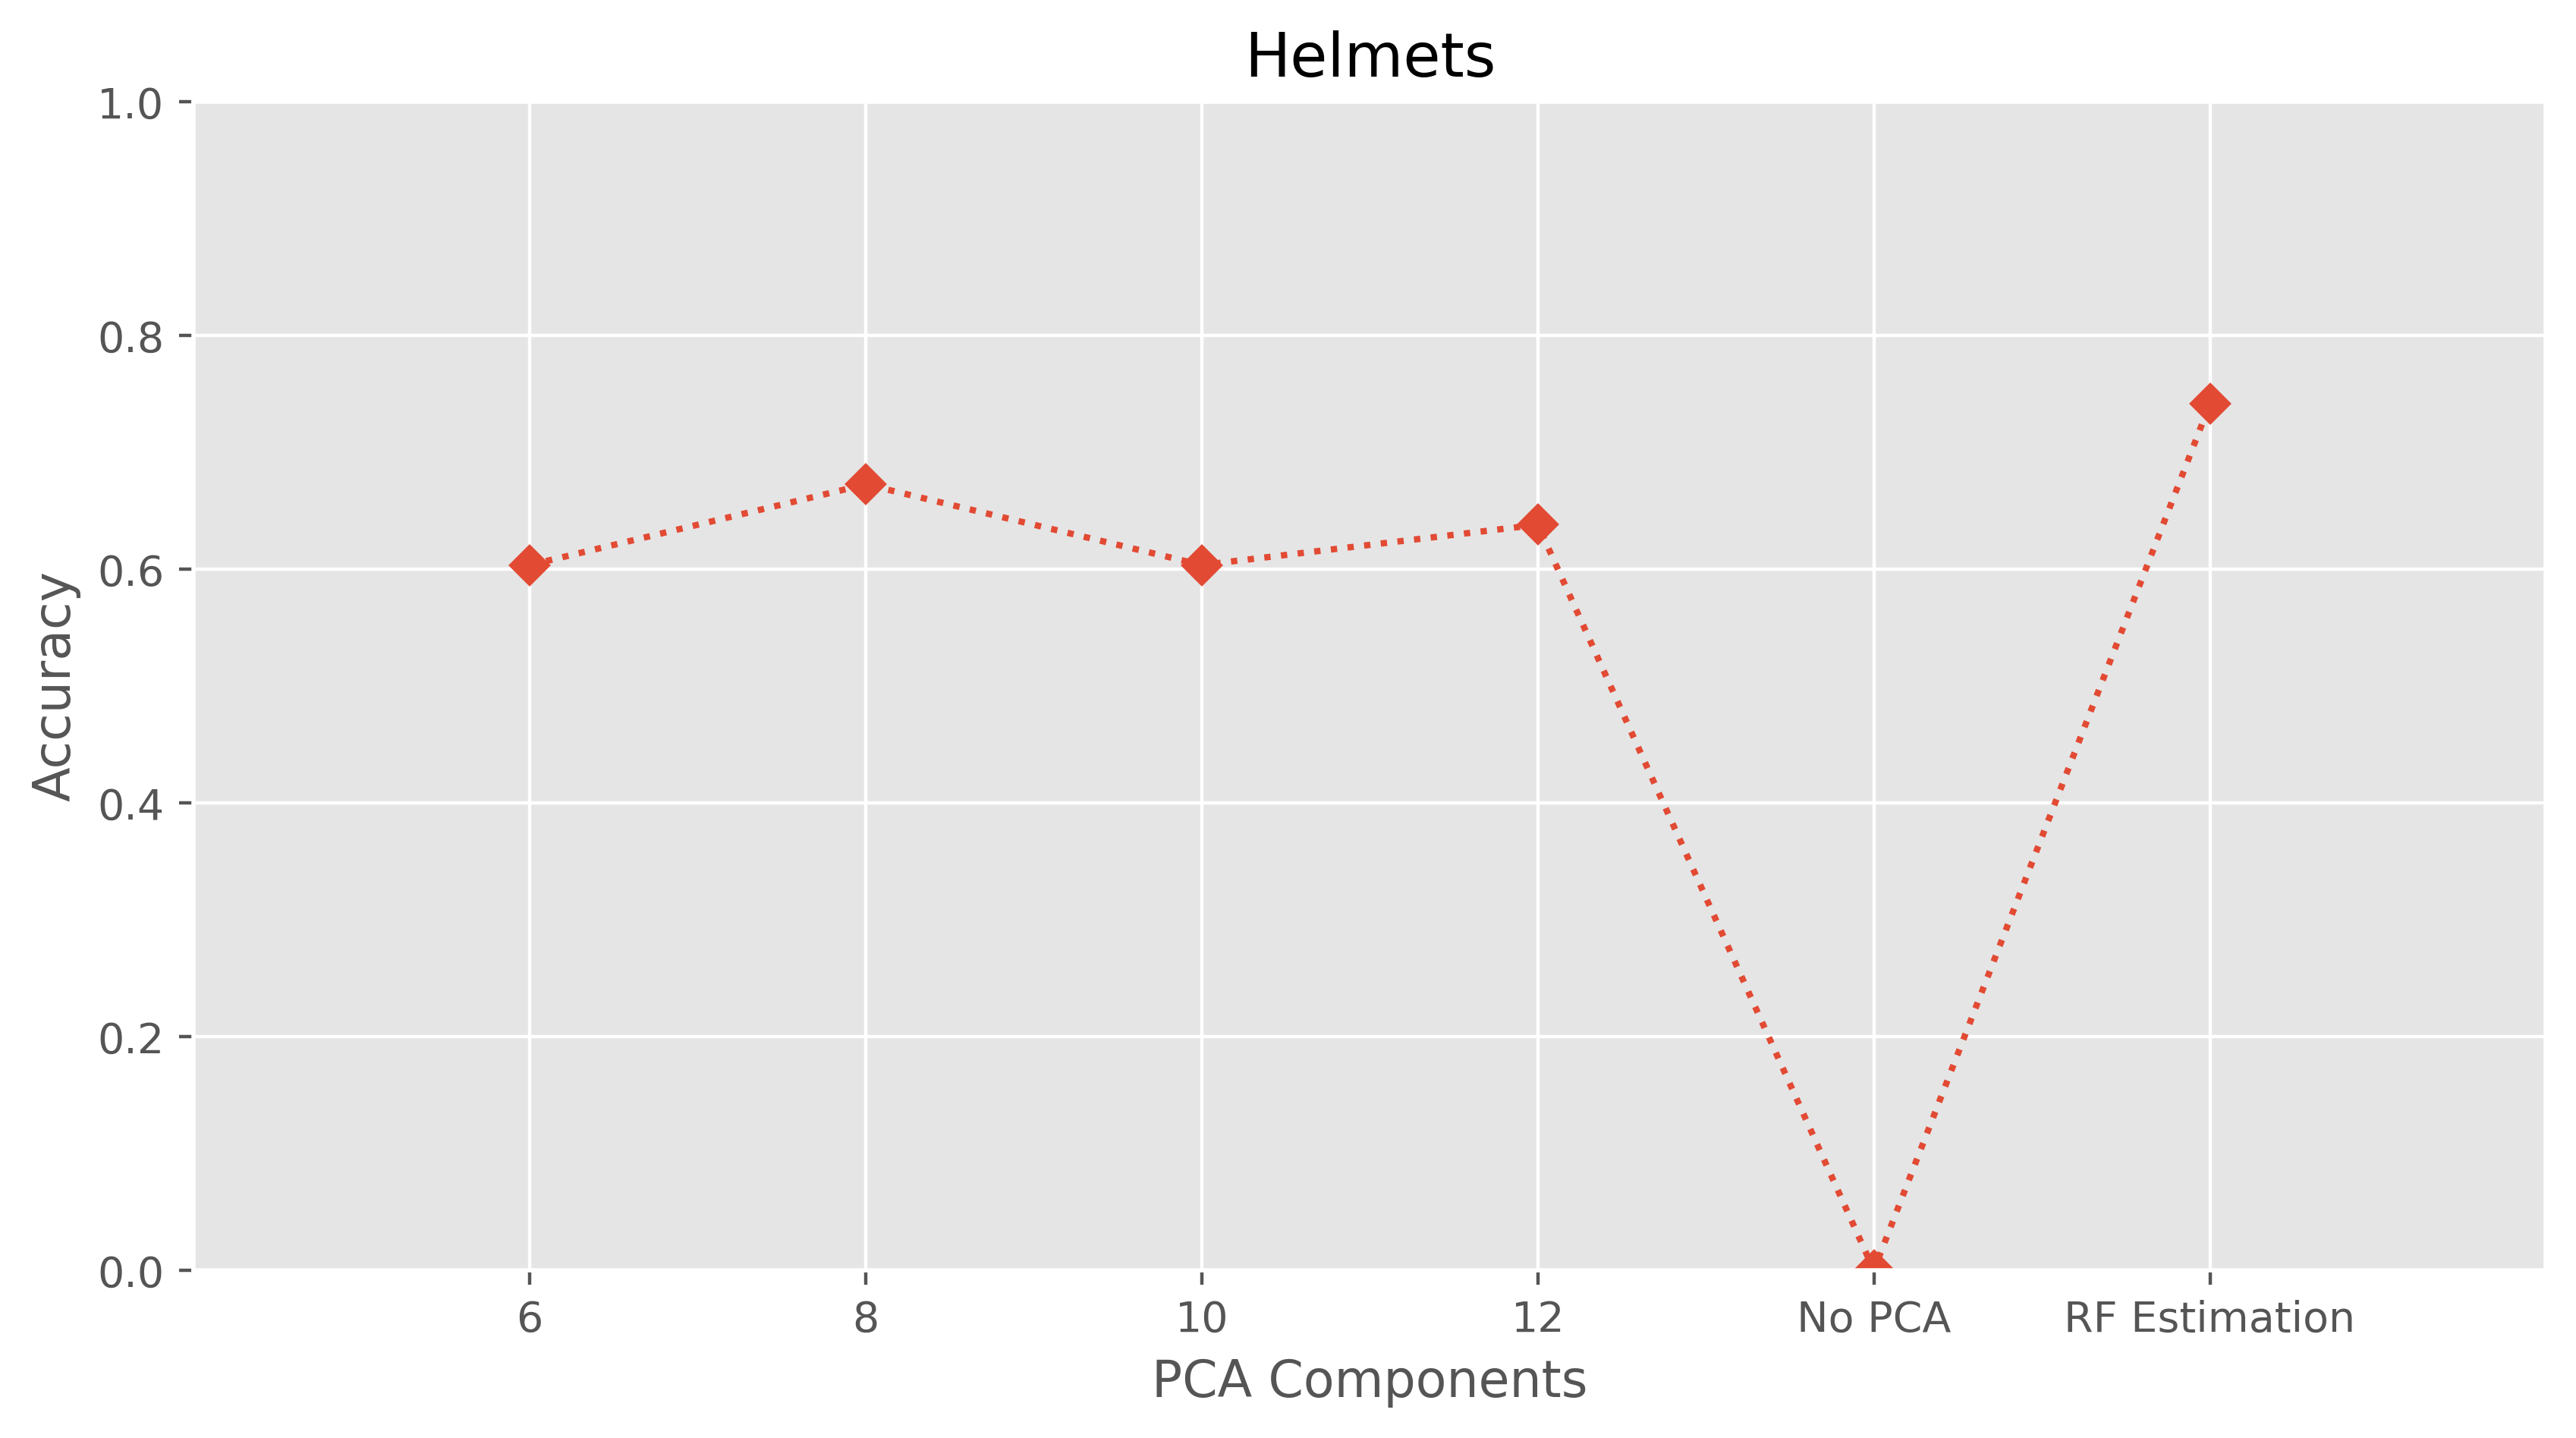

In [85]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5), dpi=400)
ax = plt.subplot(111)
ax.plot(range(1, 7), np.concatenate(
    (results_rf, [acc_rf]), axis=0), marker='D', linestyle=':', label='Random Forest')
ax.set_xlim([0, 7])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1, 7))
ax.set_xticklabels(['6', '8', '10', '12', 'No PCA', "RF Estimation"])
ax.set_ylim([0, 1])
ax.set_title('Helmets')


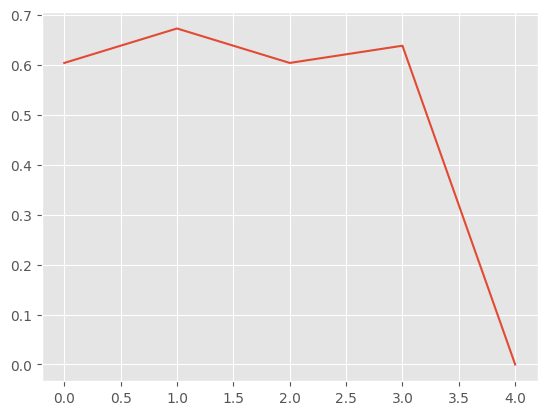

In [86]:
plt.plot(results_rf)


#### - Using HOG

In [87]:
train = 0.8
test = 1-train


In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels, test_size=test)


In [89]:
#Imagens Segmentadas

c_rf = RandomForestClassifier()
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy Random Forest: {}'.format(acc_rf))


Accuracy Random Forest: 0.9482758620689655


In [90]:
#Imagens Segmentadas

acc_rf = []
c_rf = RandomForestClassifier()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        hog_features, labels, test_size=test)
    c_rf.fit(X_train, y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Mean accuracy Random Forest: 0.9115517241379311+-0.03844904901031832


In [91]:

def rf_parameter_estimation(xEst, yEst):

    clf = RandomForestClassifier(n_estimators=20)
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10, 1000, 50),
                       "max_depth": range(1, 100),
                       "max_features": sp_randint(1, xEst.shape[1]),
                       "min_samples_split": sp_randint(2, xEst.shape[1]),
                       "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                       "bootstrap": [True, False],
                       "criterion": ["gini", "entropy"]}

    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search, scoring=make_scorer(accuracy_score))

    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))


In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test)


In [93]:
start = time.time()

parameters = rf_parameter_estimation(X_train, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)

end = time.time()
print(end - start)


Model with rank: 1
Mean validation score: 0.742 (std: 0.066)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 48, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 460}
Model with rank: 2
Mean validation score: 0.711 (std: 0.079)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 41, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 560}
Model with rank: 3
Mean validation score: 0.707 (std: 0.063)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 41, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 960}
66.95636010169983


In [94]:
print('Random Forest Accuracy: ',acc_rf)

Random Forest Accuracy:  0.7068965517241379


##### Classification using PCA

In [95]:
components = [6,8,10,12]

In [96]:
def pca(X_train, X_test, y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train, y_train)
    transform = pca.transform(X_test)
    return transform


In [97]:
results_rf = np.zeros(5)

start = time.time()
for id_comp, comp in enumerate(components):

    print('-------------', 'n comp. = ', comp, '-------------')

    X_train_pca = pca(X_train, X_train, y_train, comp)

    X_test_pca = pca(X_train, X_test, y_train, comp)

    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca, y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc


end = time.time()
print(end - start)


------------- n comp. =  6 -------------
Model with rank: 1
Mean validation score: 0.637 (std: 0.069)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 57, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 510}
Model with rank: 2
Mean validation score: 0.623 (std: 0.088)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 76, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160}
Model with rank: 3
Mean validation score: 0.619 (std: 0.077)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 70, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 310}
------------- n comp. =  8 -------------
Model with rank: 1
Mean validation score: 0.623 (std: 0.079)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 76, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 910}
Model with rank: 2
Mean validation sc

Text(0.5, 1.0, 'Helmets')

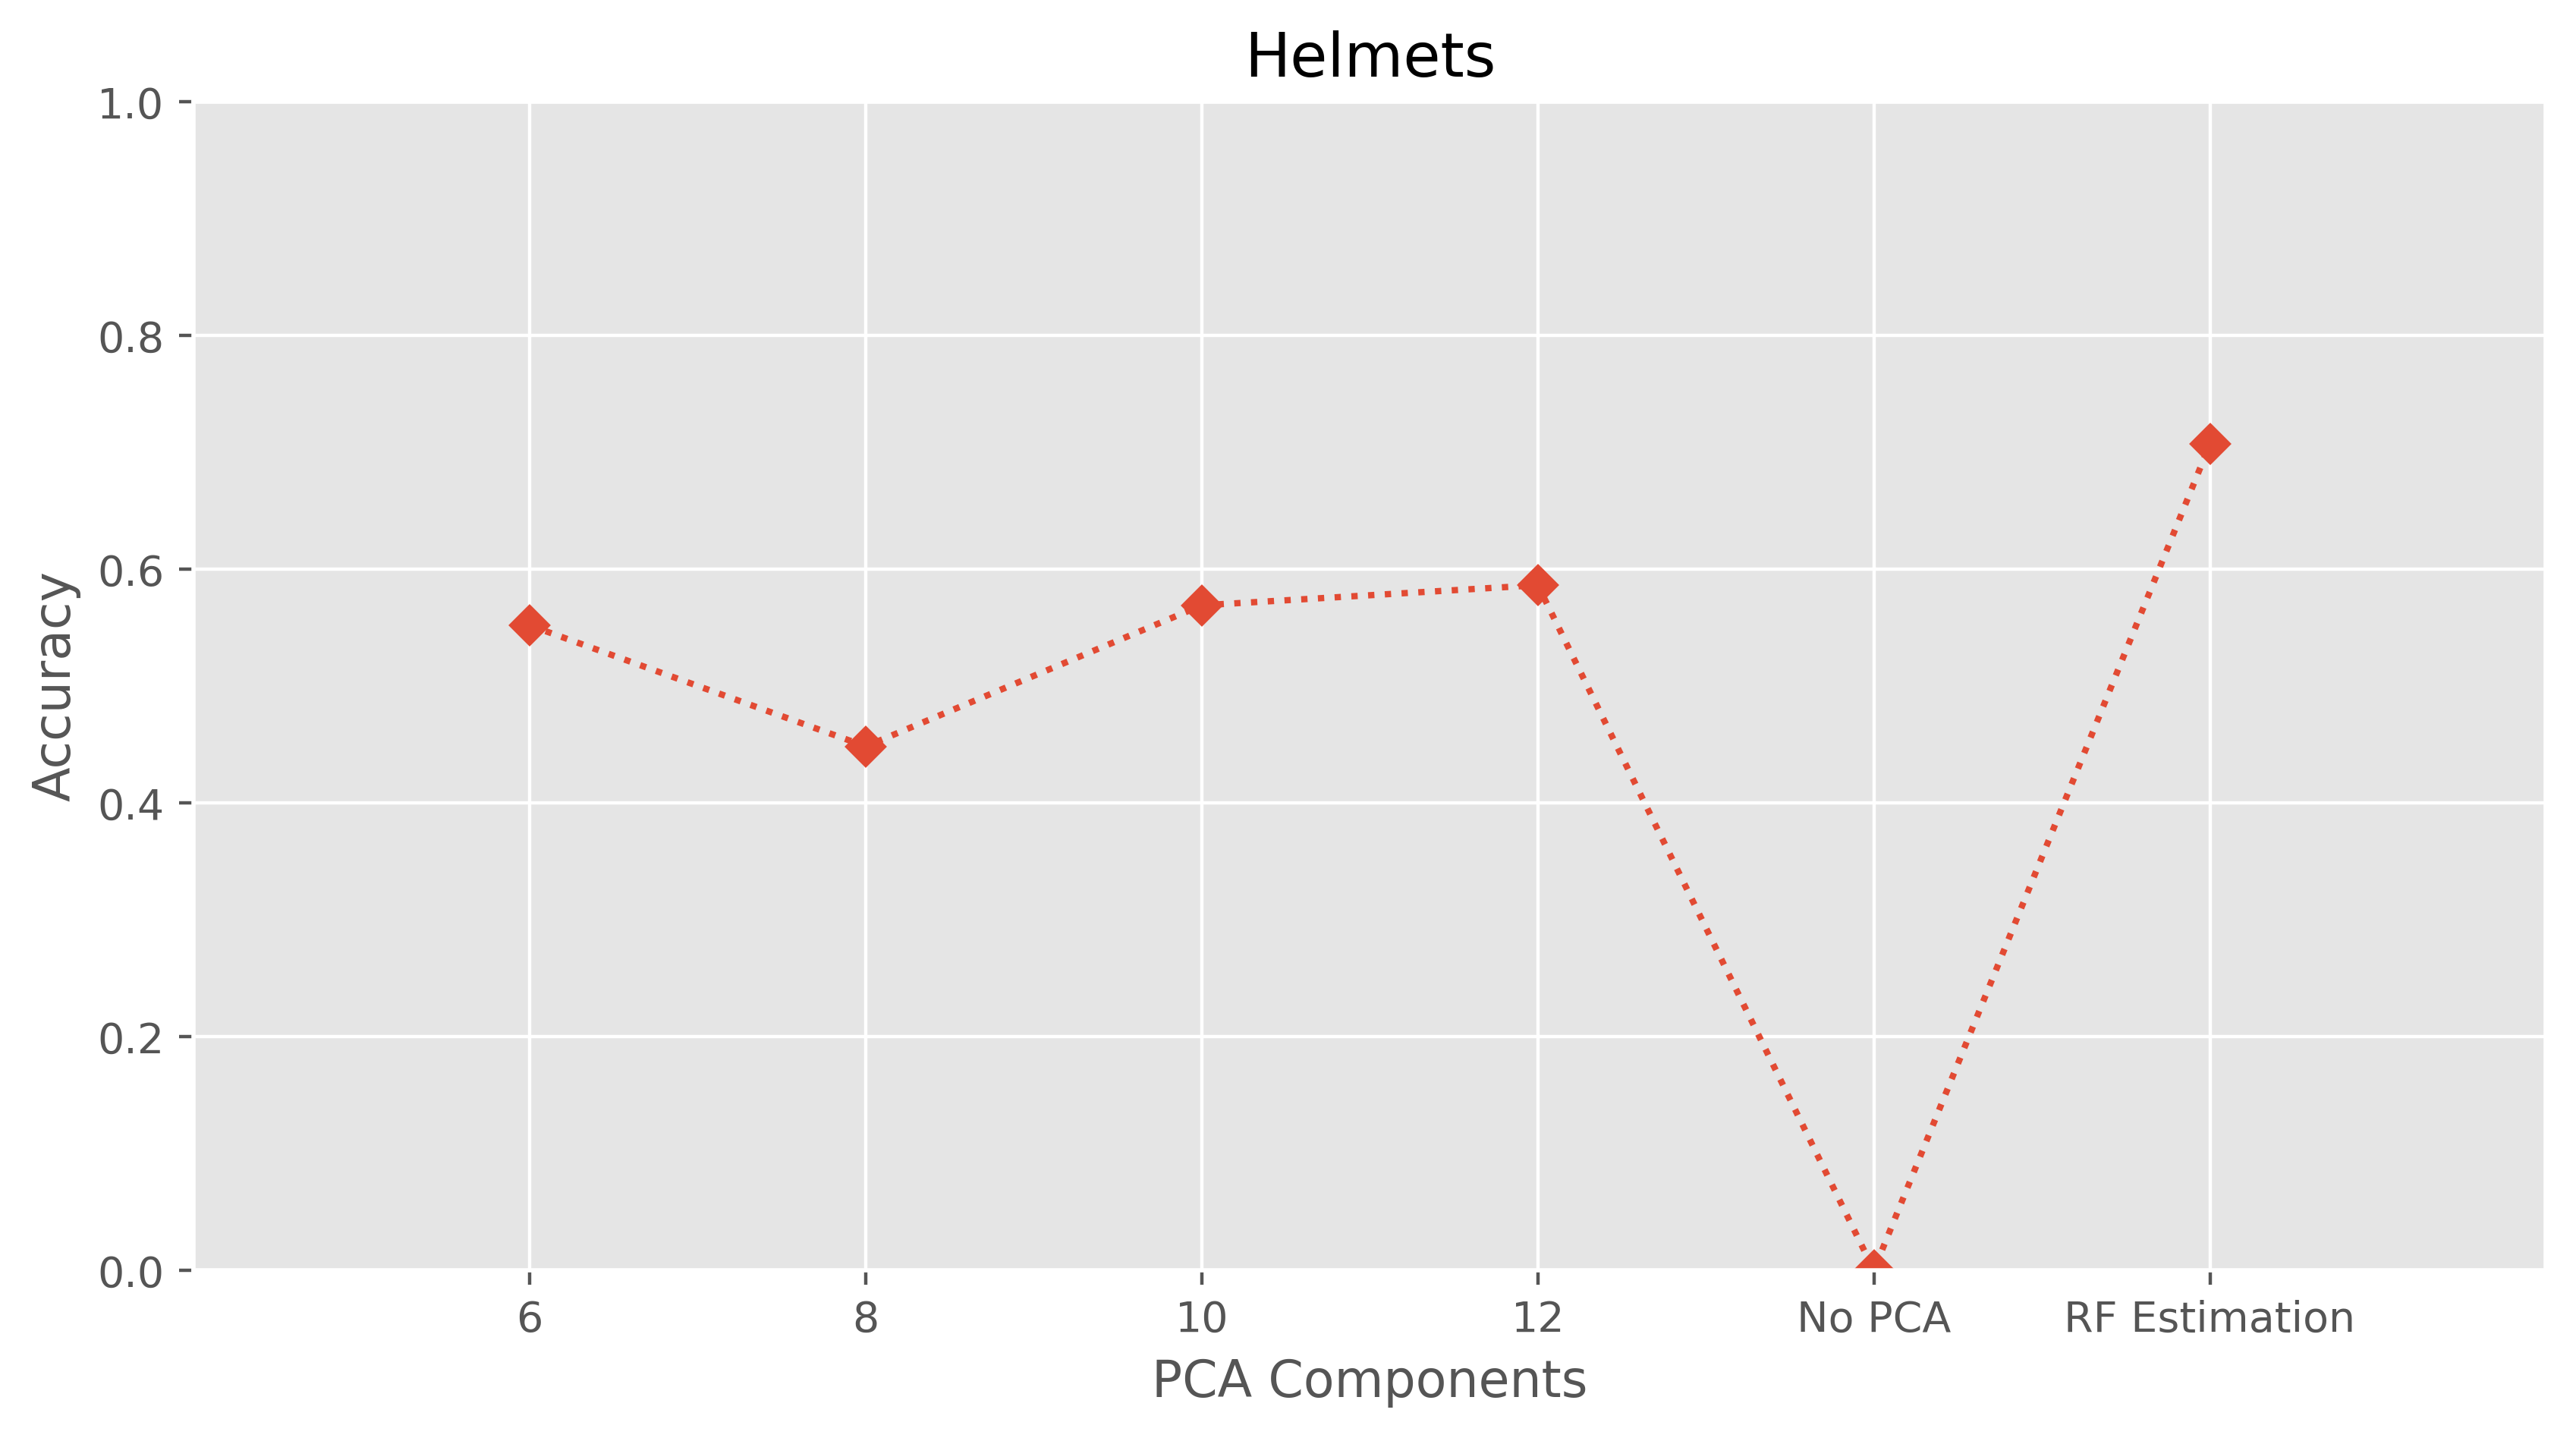

In [98]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5), dpi=400)
ax = plt.subplot(111)
ax.plot(range(1, 7), np.concatenate(
    (results_rf, [acc_rf]), axis=0), marker='D', linestyle=':', label='Random Forest')
ax.set_xlim([0, 7])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1, 7))
ax.set_xticklabels(['6', '8', '10', '12', 'No PCA', "RF Estimation"])
ax.set_ylim([0, 1])
ax.set_title('Helmets')


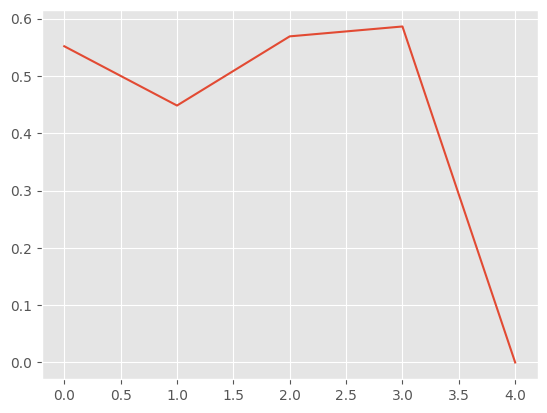

In [99]:
plt.plot(results_rf)


### Using SVC

#### - Using GLCM

In [102]:
train = 0.8
test = 1-train

In [103]:
X_train, X_test, y_train, y_test = train_test_split(
                        features, labels, test_size=test)


In [112]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy SVC: {}'.format(acc_rf))


Accuracy SVC: 0.603448275862069


In [113]:
#Imagens normais
X_train, X_test, y_train, y_test = train_test_split(
    features_2, labels, test_size=test)

svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy SVC: {}'.format(acc_rf))


Accuracy SVC: 0.5517241379310345


In [114]:
epochs = 10
acc_rf = []
c_rf = SVC(kernel='linear')
for i in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test)
    svc = SVC(kernel='linear', C=1)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Imagens Filtradas - Mean accuracy SVC: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Imagens Filtradas - Mean accuracy SVC: 0.5137931034482759+-0.051609067403778505


In [115]:
epochs = 5
acc_rf = []
c_rf = SVC(kernel='linear')
for i in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(
        features_2, labels, test_size=test)
    svc = SVC(kernel='linear', C=1)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Imagens Normais - Mean accuracy SVC: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Imagens Normais - Mean accuracy SVC: 0.506896551724138+-0.03550217289995516


#### - Using HOG

In [116]:
train = 0.8
test = 1-train


In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels, test_size=test)


In [118]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy SVC: {}'.format(acc_rf))

Accuracy SVC: 0.9655172413793104


In [119]:
epochs = 10
acc_rf = []
c_rf = SVC(kernel='linear')
for i in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(
        hog_features, labels, test_size=test)
    svc = SVC(kernel='linear', C=1)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Imagens Filtradas - Mean accuracy SVC: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Imagens Filtradas - Mean accuracy SVC: 0.9586206896551724+-0.03465474352110651


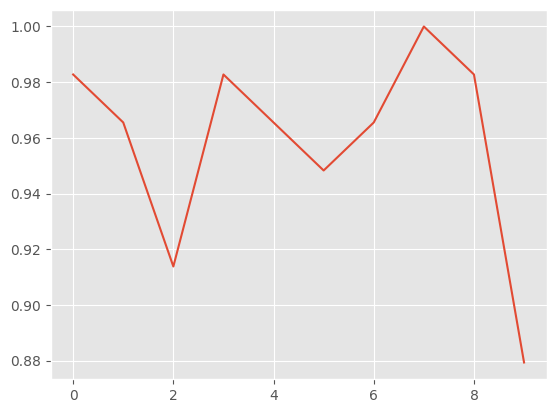

In [120]:
plt.plot(acc_rf)


## Etapa 05 - K-Fold

In [124]:
# Define o número de folds
k = 5

# Cria o objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [125]:
accuracies = []
precision_list = []
f1_list = []
rec_list = []

# Iterando sobre os folds
for train_idx, test_idx in kf.split(hog_features):
    X_train, X_test = hog_features[train_idx], hog_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    model = SVC(kernel='linear')
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    accuracies.append(accuracy)
    print("-=-")
    print(f"Accuracy: {accuracy}")
    
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_pred, y_test, average='macro')
    precision_list.append(precision)
    print(f"Precision: {precision}")
    f1 = f1_score(y_pred, y_test, average="macro")
    f1_list.append(f1)
    print(f"F1-Score: {f1}")
    rec = recall_score(y_pred, y_test, average="macro")
    rec_list.append(rec)
    print(f"Recall Score: {rec}")
    print("-=-")

    
mean_accuracy = sum(accuracies) / len(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = sum(precision_list) / len(precision_list)
std_precision = np.std(precision_list)

mean_f1 = sum(f1_list) / len(f1_list)
std_f1 = np.std(f1_list)

mean_recall = sum(rec_list) / len(rec_list)
std_recall = np.std(rec_list)

print("-=-=-=-=-=-")
print(f"Acurácia média: {mean_accuracy:.3f}")
print(f"Desvio padrão: {std_accuracy:.3f}")
print("-=-=-=-=-=-")
print(f"Precisao média: {mean_precision:.3f}")
print(f"Desvio padrão: {std_precision:.3f}")
print("-=-=-=-=-=-")
print(f"F1 média: {mean_f1:.3f}")
print(f"Desvio padrão: {std_f1:.3f}")
print("-=-=-=-=-=-")
print(f"Recall média: {mean_recall:.3f}")
print(f"Desvio padrão: {std_recall:.3f}")
print("-=-=-=-=-=-")


-=-
Accuracy: 0.9827586206896551
Precision: 0.984375
F1-Score: 0.9843137254901961
Recall Score: 0.9861111111111112
-=-
-=-
Accuracy: 0.9473684210526315
Precision: 0.934375
F1-Score: 0.9426470588235294
Recall Score: 0.9668803418803419
-=-
-=-
Accuracy: 0.9649122807017544
Precision: 0.9613095238095238
F1-Score: 0.9643150966680378
Recall Score: 0.9722222222222222
-=-
-=-
Accuracy: 0.9649122807017544
Precision: 0.9722222222222222
F1-Score: 0.9665178571428572
Recall Score: 0.96875
-=-
-=-
Accuracy: 0.9473684210526315
Precision: 0.9464285714285714
F1-Score: 0.9425626456876457
Recall Score: 0.9513888888888888
-=-
-=-=-=-=-=-
Acurácia média: 0.961
Desvio padrão: 0.013
-=-=-=-=-=-
Precisao média: 0.960
Desvio padrão: 0.018
-=-=-=-=-=-
F1 média: 0.960
Desvio padrão: 0.016
-=-=-=-=-=-
Recall média: 0.969
Desvio padrão: 0.011
-=-=-=-=-=-


## Etapa 06 - Metricas

### Usando o modelo SVC

In [126]:
#Usando o HOG

X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels, test_size=test)

svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_rf}")
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1-Score: {f1}")
rec = recall_score(y_test, y_pred, average="macro")
print(f"Recall Score: {rec}")


Accuracy: 0.9482758620689655
Precision: 0.9625
F1-Score: 0.9509525401069518
Recall Score: 0.9513888888888888


In [127]:
#Usando o GLCM

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test)

svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_rf}")
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1-Score: {f1}")
rec = recall_score(y_test, y_pred, average="macro")
print(f"Recall Score: {rec}")


Accuracy: 0.6551724137931034
Precision: 0.6675099206349207
F1-Score: 0.6538577231591938
Recall Score: 0.6598214285714286


In [128]:
#Usando o GLCM nas imagens originais

X_train, X_test, y_train, y_test = train_test_split(
    features_2, labels, test_size=test)

svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_rf}")
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1-Score: {f1}")
rec = recall_score(y_test, y_pred, average="macro")
print(f"Recall Score: {rec}")


Accuracy: 0.5517241379310345
Precision: 0.5545634920634921
F1-Score: 0.5337719298245615
Recall Score: 0.5602678571428572


### Usando o modelo RandomForestClassifier

In [129]:
#Usando o HOG

X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels, test_size=test)

svc = RandomForestClassifier()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_rf}")
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1-Score: {f1}")
rec = recall_score(y_test, y_pred, average="macro")
print(f"Recall Score: {rec}")


Accuracy: 0.9137931034482759
Precision: 0.9222222222222222
F1-Score: 0.9031928780284044
Recall Score: 0.9


In [130]:
#Usando o GLCM

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test)

svc = RandomForestClassifier()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_rf}")
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1-Score: {f1}")
rec = recall_score(y_test, y_pred, average="macro")
print(f"Recall Score: {rec}")


Accuracy: 0.7241379310344828
Precision: 0.7399305555555555
F1-Score: 0.7443813255514022
Recall Score: 0.7624961843711844


In [131]:
#Usando o GLCM nas imagens originais

X_train, X_test, y_train, y_test = train_test_split(
    features_2, labels, test_size=test)

svc = RandomForestClassifier()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_rf}")
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1-Score: {f1}")
rec = recall_score(y_test, y_pred, average="macro")
print(f"Recall Score: {rec}")


Accuracy: 0.6206896551724138
Precision: 0.6698450854700855
F1-Score: 0.5984237984237984
Recall Score: 0.610813492063492
